In [1]:
import numpy as np
import pandas as pd 
from sklearn.metrics import accuracy_score
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
pio.templates.default = "plotly_white"
import matplotlib.pyplot as plt
import os
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error

In [2]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [3]:
folder_path = 'C:\\Users\\akshi_sh9bvdj\\Downloads\\archive\\stock_market_data\\forbes2000\\csv'
csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]

In [4]:
dataframes = [pd.read_csv(os.path.join(folder_path, file)) for file in csv_files]

In [5]:
# Combine All the datasets into 1
dataframes = []
for file in csv_files:
    # Read the CSV
    df = pd.read_csv(os.path.join(folder_path, file))
    
    # Add a new column representing the filename without the ".csv" extension
    filename_without_extension = os.path.splitext(file)[0]
    df.insert(0, 'Name', filename_without_extension)
    df['Name'] = filename_without_extension
    dataframes.append(df)

# Concatenate all DataFrames
stocks_df = pd.concat(dataframes, ignore_index=True)

# Save new merged Dataset
stocks_df.to_csv('merged_dataset_with_id.csv', index=False)

In [6]:
# Convert Date column to datetime
stocks_df['Date'] = pd.to_datetime(stocks_df['Date'], format='%d-%m-%Y')
print(stocks_df)

          Name       Date        Low       Open      Volume       High  \
0            A 1999-11-18  28.612303  32.546494  62546380.0  35.765381   
1            A 1999-11-19  28.478184  30.713518  15234146.0  30.758226   
2            A 1999-11-22  28.657009  29.551144   6577870.0  31.473534   
3            A 1999-11-23  28.612303  30.400572   5975611.0  31.205294   
4            A 1999-11-24  28.612303  28.701717   4843231.0  29.998213   
...        ...        ...        ...        ...         ...        ...   
5601966  ZURVY 2022-12-06  47.810001  48.029999     42700.0  48.209999   
5601967  ZURVY 2022-12-07  47.740002  47.959999     74800.0  48.130001   
5601968  ZURVY 2022-12-08  47.880001  47.950001     72300.0  48.290001   
5601969  ZURVY 2022-12-09  48.259998  48.470001     65600.0  48.740002   
5601970  ZURVY 2022-12-12  48.044998  48.189999     13244.0  48.189999   

             Close  Adjusted Close  
0        31.473534       27.066582  
1        28.880545       24.836662  


## Long term- Short term Memory 

### Introduction : 

LSTMs are widely used for sequence prediction problems and have proven to be extremely effective. The reason they work so well is that LSTM is able to store past information that is important and forget the information that is not. LSTM has three gates:
 The input gate: The input gate adds information to the cell state The forget gate: It removes the information that is no longer required by the model The output gate: Output Gate at LSTM selects the information to be shown as output .The LSTM model can be tuned for various parameters such as changing the number of LSTM layers, adding dropout value, or increasing the number of epochs. 
 
### We will implement the LSTM model for only Tesla and Microsoft stocks

In [23]:
# Filter out Tesla data
tesla_df = stocks_df[stocks_df['Name'] == 'TSLA']

# Sort the dataframe by Date
tesla_df.sort_values(by='Date', inplace=True)
print(tesla_df)

         Name       Date         Low        Open       Volume        High  \
5031552  TSLA 2010-06-29    1.169333    1.266667  281494500.0    1.666667   
5031553  TSLA 2010-06-30    1.553333    1.719333  257806500.0    2.028000   
5031554  TSLA 2010-07-01    1.351333    1.666667  123282000.0    1.728000   
5031555  TSLA 2010-07-02    1.247333    1.533333   77097000.0    1.540000   
5031556  TSLA 2010-07-06    1.055333    1.333333  103003500.0    1.333333   
...       ...        ...         ...         ...          ...         ...   
5034684  TSLA 2022-12-06  175.330002  181.220001   92150800.0  183.649994   
5034685  TSLA 2022-12-07  172.220001  175.029999   84213300.0  179.380005   
5034686  TSLA 2022-12-08  169.059998  172.199997   97624500.0  175.199997   
5034687  TSLA 2022-12-09  173.360001  173.839996  104746600.0  182.500000   
5034688  TSLA 2022-12-12  170.389999  176.100006   36780366.0  177.359894   

              Close  Adjusted Close  
5031552    1.592667        1.592667  

C:\Users\akshi_sh9bvdj\AppData\Local\Temp\ipykernel_5468\3533593648.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tesla_df.sort_values(by='Date', inplace=True)


In [30]:
tesla_df.isnull().sum()
# Assuming 'Date' column is present in tesla_df and is properly formatted
tesla_df['Date'] = pd.to_datetime(tesla_df['Date'])

# Set 'Date' column as the index
tesla_df.set_index('Date', inplace=True)

C:\Users\akshi_sh9bvdj\AppData\Local\Temp\ipykernel_5468\1996530677.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tesla_df['Date'] = pd.to_datetime(tesla_df['Date'])


In [31]:
tesla_model_df= tesla_df.filter(['Close'])
dataset= tesla_model_df.values

# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .95 ))

training_data_len

2981

In [32]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.00131893],
       [0.00130915],
       [0.00100428],
       ...,
       [0.42156919],
       [0.43528837],
       [0.41851233]])

In [33]:
train_data = scaled_data[0:int(training_data_len), :]

In [34]:
print(train_data)

[[0.00131893]
 [0.00130915]
 [0.00100428]
 ...
 [0.71599756]
 [0.71273689]
 [0.70723454]]


In [38]:
# Split the data into x_train and y_train data sets
x_train = []
y_train = []


In [39]:
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()

[array([1.31893362e-03, 1.30915180e-03, 1.00428027e-03, 5.54310805e-04,
       5.05407544e-05, 0.00000000e+00, 2.70634579e-04, 2.60852469e-04,
       2.03792057e-04, 3.81495574e-04, 6.58652434e-04, 6.66803171e-04,
       7.89077648e-04, 9.96129534e-04, 7.33645693e-04, 7.20604046e-04,
       8.47769140e-04, 8.95047734e-04, 8.39618402e-04, 7.74404629e-04,
       8.02119295e-04, 7.41799054e-04, 6.74953909e-04, 8.34727493e-04,
       1.00264919e-03, 8.90156824e-04, 7.58100530e-04, 6.17893497e-04,
       6.19524578e-04, 5.26596139e-04, 3.42368009e-04, 2.93458335e-04,
       4.10841611e-04, 4.85837203e-04, 5.46160067e-04, 4.84206122e-04,
       4.87468283e-04, 5.38006705e-04, 7.05931027e-04, 5.54310805e-04,
       6.68434252e-04, 6.43979415e-04, 6.35826345e-04, 6.63543343e-04,
       5.99960650e-04, 7.58100530e-04, 8.57551250e-04, 8.55919878e-04,
       7.72773549e-04, 8.31465041e-04, 8.00490546e-04, 7.12453017e-04,
       8.02119295e-04, 8.67333068e-04, 1.00754010e-03, 8.37987322e-04,
     

In [40]:
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

In [41]:
# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(2921, 60, 1)

In [42]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

C:\Users\akshi_sh9bvdj\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2921/2921 ━━━━━━━━━━━━━━━━━━━━ 81s 26ms/step - loss: 0.0022


In [18]:
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

In [19]:
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))
x_test.shape

(156, 60, 1)

In [20]:
#Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


15.962289123685679

C:\Users\akshi_sh9bvdj\AppData\Local\Temp\ipykernel_5468\3905864600.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


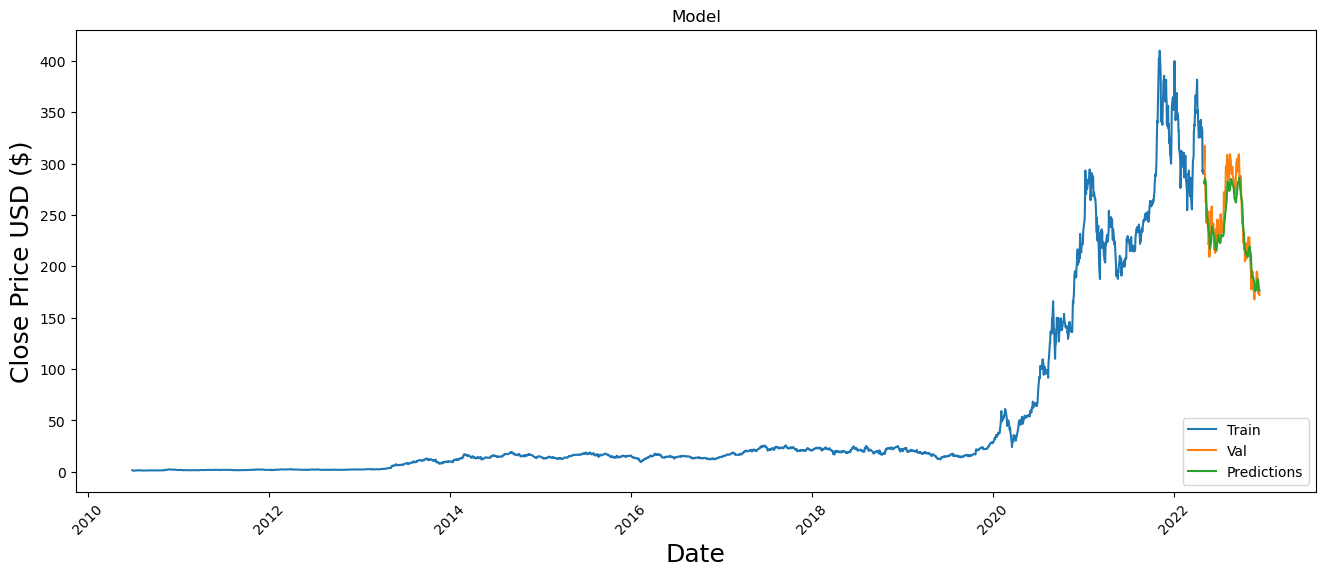

In [43]:
# Plot the data
train = tesla_model_df[:training_data_len]
valid = tesla_model_df[training_data_len:]
valid['Predictions'] = predictions



# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')

# Format the date on the x-axis
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

plt.show()


In [44]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
# Extract actual and predicted values
actual_values = valid['Close']
predicted_values = valid['Predictions']

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(actual_values, predicted_values)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(actual_values, predicted_values)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Absolute Error (MAE): 12.805823301657652
Mean Squared Error (MSE): 254.79467406813413
Root Mean Squared Error (RMSE): 15.962289123685679


In [45]:
from sklearn.metrics import r2_score
import statsmodels.api as sm
# Calculate R-squared
r_squared = r2_score(actual_values, predicted_values)

# Number of predictors in the model
num_predictors = len(predicted_values)

# Calculate Adjusted R-squared
# Note: The -1 is due to the intercept term in the model
adjusted_r_squared = 1 - (1 - r_squared) * ((len(actual_values) - 1) / (len(actual_values) - num_predictors - 1))

print("R-squared:", r_squared)
print("Adjusted R-squared:", adjusted_r_squared)

R-squared: 0.8389518741296215
Adjusted R-squared: 25.962459509908673


In [50]:
#microsoft
# Filter out msft data
msft_df = stocks_df[stocks_df['Name'] == 'MSFT']

# Sort the dataframe by Date
msft_df.sort_values(by='Date', inplace=True)
print(msft_df)

         Name       Date         Low        Open        Volume        High  \
3381936  MSFT 1986-03-13    0.088542    0.088542  1.031789e+09    0.101563   
3381937  MSFT 1986-03-14    0.097222    0.097222  3.081600e+08    0.102431   
3381938  MSFT 1986-03-17    0.100694    0.100694  1.331712e+08    0.103299   
3381939  MSFT 1986-03-18    0.098958    0.102431  6.776640e+07    0.103299   
3381940  MSFT 1986-03-19    0.097222    0.099826  4.789440e+07    0.100694   
...       ...        ...         ...         ...           ...         ...   
3391195  MSFT 2022-12-06  243.779999  250.820007  2.246370e+07  251.860001   
3391196  MSFT 2022-12-07  242.210007  244.830002  2.048150e+07  246.160004   
3391197  MSFT 2022-12-08  243.059998  244.839996  2.261180e+07  248.740005   
3391198  MSFT 2022-12-09  244.160004  244.699997  2.060710e+07  248.309998   
3391199  MSFT 2022-12-12  247.179993  247.445007  1.000066e+07  252.151596   

              Close  Adjusted Close  
3381936    0.097222      

C:\Users\akshi_sh9bvdj\AppData\Local\Temp\ipykernel_5468\3414701632.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  msft_df.sort_values(by='Date', inplace=True)


In [51]:
msft_df.isnull().sum()


Name              0
Date              0
Low               0
Open              0
Volume            0
High              0
Close             0
Adjusted Close    0
dtype: int64

In [52]:
# Assuming 'Date' column is present in msft_df and is properly formatted
msft_df['Date'] = pd.to_datetime(msft_df['Date'])

# Set 'Date' column as the index
msft_df.set_index('Date', inplace=True)

C:\Users\akshi_sh9bvdj\AppData\Local\Temp\ipykernel_5468\1519385047.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  msft_df['Date'] = pd.to_datetime(msft_df['Date'])


In [53]:
msft_model_df= msft_df.filter(['Close'])
dataset_msft= msft_model_df.values
# Get the number of rows to train the model on
training_data_len_msft = int(np.ceil( len(dataset) * .95 ))

training_data_len_msft

2981

In [54]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data_msft = scaler.fit_transform(dataset_msft)

scaled_data_msft

array([[2.02437369e-05],
       [3.03656054e-05],
       [3.54294502e-05],
       ...,
       [7.20978155e-01],
       [7.15205905e-01],
       [7.30190465e-01]])

In [55]:
train_data_msft = scaled_data[0:int(training_data_len_msft), :]

In [56]:
print(train_data_msft)

[[0.00131893]
 [0.00130915]
 [0.00100428]
 ...
 [0.71599756]
 [0.71273689]
 [0.70723454]]


In [57]:
# Split the data into x_train and y_train data sets
x_train_msft = []
y_train_msft = []
for i in range(60, len(train_data_msft)):
    x_train_msft.append(train_data_msft[i-60:i, 0])
    y_train_msft.append(train_data_msft[i, 0])
    if i<= 61:
        print(x_train_msft)
        print(y_train_msft)
        print()

[array([1.31893362e-03, 1.30915180e-03, 1.00428027e-03, 5.54310805e-04,
       5.05407544e-05, 0.00000000e+00, 2.70634579e-04, 2.60852469e-04,
       2.03792057e-04, 3.81495574e-04, 6.58652434e-04, 6.66803171e-04,
       7.89077648e-04, 9.96129534e-04, 7.33645693e-04, 7.20604046e-04,
       8.47769140e-04, 8.95047734e-04, 8.39618402e-04, 7.74404629e-04,
       8.02119295e-04, 7.41799054e-04, 6.74953909e-04, 8.34727493e-04,
       1.00264919e-03, 8.90156824e-04, 7.58100530e-04, 6.17893497e-04,
       6.19524578e-04, 5.26596139e-04, 3.42368009e-04, 2.93458335e-04,
       4.10841611e-04, 4.85837203e-04, 5.46160067e-04, 4.84206122e-04,
       4.87468283e-04, 5.38006705e-04, 7.05931027e-04, 5.54310805e-04,
       6.68434252e-04, 6.43979415e-04, 6.35826345e-04, 6.63543343e-04,
       5.99960650e-04, 7.58100530e-04, 8.57551250e-04, 8.55919878e-04,
       7.72773549e-04, 8.31465041e-04, 8.00490546e-04, 7.12453017e-04,
       8.02119295e-04, 8.67333068e-04, 1.00754010e-03, 8.37987322e-04,
     

In [58]:
# Convert the x_train and y_train to numpy arrays 
x_train_msft, y_train_msft = np.array(x_train_msft), np.array(y_train_msft)
# Reshape the data
x_train_msft= np.reshape(x_train_msft, (x_train_msft.shape[0], x_train_msft.shape[1], 1))
x_train_msft.shape

(2921, 60, 1)

In [59]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train_msft.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train_msft, y_train_msft, batch_size=1, epochs=1)

C:\Users\akshi_sh9bvdj\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2921/2921 ━━━━━━━━━━━━━━━━━━━━ 80s 26ms/step - loss: 0.0027


In [60]:
test_data_msft = scaled_data_msft[training_data_len_msft - 60: , :]
# Create the data sets x_test and y_test
x_test_msft = []
y_test_msft = dataset_msft[training_data_len_msft:, :]
for i in range(60, len(test_data_msft)):
    x_test_msft.append(test_data_msft[i-60:i, 0])

In [61]:
# Convert the data to a numpy array
x_test_msft = np.array(x_test_msft)

# Reshape the data
x_test_msft= np.reshape(x_test_msft, (x_test_msft.shape[0], x_test_msft.shape[1], 1 ))
x_test_msft.shape

(6283, 60, 1)

In [62]:
#Get the models predicted price values 
predictions = model.predict(x_test_msft)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test_msft) ** 2)))
rmse

197/197 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step


13.63251812811608

C:\Users\akshi_sh9bvdj\AppData\Local\Temp\ipykernel_5468\21257766.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


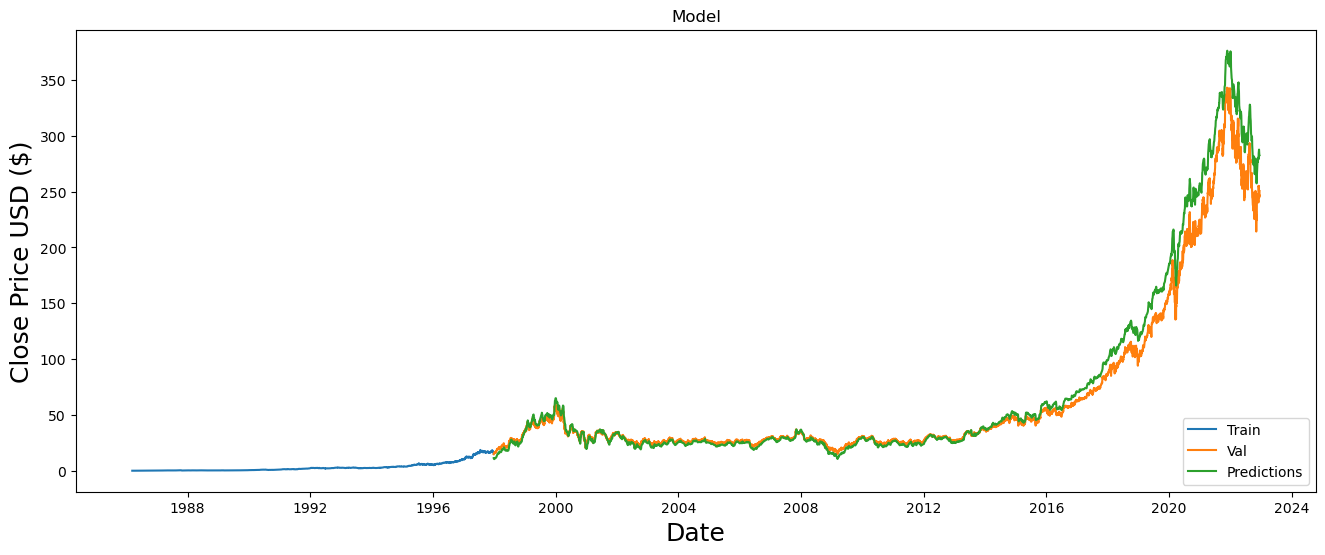

In [63]:
# Plot the data
train = msft_model_df[:training_data_len_msft]
valid = msft_model_df[training_data_len_msft:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [64]:
import numpy as np
# Extract actual and predicted values
actual_values = valid['Close']
predicted_values = valid['Predictions']

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(actual_values, predicted_values)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(actual_values, predicted_values)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Absolute Error (MAE): 7.703086840732641
Mean Squared Error (MSE): 185.84555051341354
Root Mean Squared Error (RMSE): 13.63251812811608


In [65]:
# Calculate R-squared
r_squared = r2_score(actual_values, predicted_values)

# Number of predictors in the model
num_predictors = len(predicted_values)

# Calculate Adjusted R-squared
# Note: The -1 is due to the intercept term in the model
adjusted_r_squared = 1 - (1 - r_squared) * ((len(actual_values) - 1) / (len(actual_values) - num_predictors - 1))

print("R-squared:", r_squared)
print("Adjusted R-squared:", adjusted_r_squared)

R-squared: 0.9647457481109465
Adjusted R-squared: 222.46721036703417
